# Telco Customer Churn - Python Analysis
### Main Objective:
1. Exploratory Data Anlaysis
2. Data Pre-processing
3. Model Building
4. Model Evaluation
---

### Import Libraries

In [1]:
# Base library
import pandas as pd
import numpy as np

# MySQL Connector
import mysql.connector
from mysql.connector import Error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Selection, cross-validation
from sklearn.model_selection import train_test_split, cross_val_score

# Data pre-processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Model
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from functools import partial
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

e:\Program\Anaconda\envs\kaggle\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load the data

In [2]:
# DB Config
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'telco_churn'
}

In [3]:
# SQL Query to load the data
sql_query = """
SELECT
    c.customerID,
    c.gender,
    c.SeniorCitizen,
    c.Partner,
    c.Dependents,
    a.tenure,
    a.Contract,
    a.PaperlessBilling,
    a.PaymentMethod,
    a.MonthlyCharges,
    a.TotalCharges,
    s.PhoneService,
    s.MultipleLines,
    s.InternetService,
    s.OnlineSecurity,
    s.OnlineBackup,
    s.DeviceProtection,
    s.TechSupport,
    s.StreamingTV,
    s.StreamingMovies,
    ch.Churn
FROM
    customers c
JOIN
    account_info a ON c.customerID = a.customerID
JOIN
    services s ON c.customerID = s.customerID
JOIN
    churn_data ch ON c.customerID = ch.customerID;
"""

# Connect to the database and load the data
# Create a variable 'df' to hold the data
df = None
conn = None # Initialize connection to None

try:
    # Establish the connection
    conn = mysql.connector.connect(**db_config)
    
    if conn.is_connected():
        print("Successfully connected to the MySQL database.")
        
        # Use pandas to execute the query and load data into a DataFrame
        df = pd.read_sql(sql_query, conn)
        
        print("Data successfully loaded into a pandas DataFrame.")

except Error as e:
    print(f"Error connecting to MySQL or fetching data: {e}")

finally:
    # Make sure to close the connection
    if conn and conn.is_connected():
        conn.close()
        print("MySQL connection is closed.")

Successfully connected to the MySQL database.
Data successfully loaded into a pandas DataFrame.
MySQL connection is closed.


C:\Users\dkpc2\AppData\Local\Temp\ipykernel_22780\3995519853.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


In [4]:
# Check if the dataset is loaded properly
if df is not None:
    print("\n--- Data Verification ---")
    
    # Check the number of rows and columns loaded
    # This should show approximately (7043, 21)
    print(f"The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
    
    # Display the first 5 rows to see what the data looks like
    print("\nFirst 5 rows of the dataset:")
    display(df.head())
    
    # Display summary info to check for null values and data types
    print("\nDataFrame Info:")
    df.info()


--- Data Verification ---
The DataFrame has 7043 rows and 21 columns.

First 5 rows of the dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,...,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,One year,Yes,Mailed check,65.6,...,Yes,No,DSL,No,Yes,No,Yes,Yes,No,No\r
1,0003-MKNFE,Male,0,No,No,9,Month-to-month,No,Mailed check,59.9,...,Yes,Yes,DSL,No,No,No,No,No,Yes,No\r
2,0004-TLHLJ,Male,0,No,No,4,Month-to-month,Yes,Electronic check,73.9,...,Yes,No,Fiber optic,No,No,Yes,No,No,No,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Month-to-month,Yes,Electronic check,98.0,...,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Month-to-month,Yes,Mailed check,83.9,...,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Yes



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   Contract          7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7032 non-null   float64
 11  PhoneService      7043 non-null   object 
 12  MultipleLines     7043 non-null   object 
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   object 
 15  OnlineBackup      7043 non-null   object 
 16  DeviceProtection  7043 no

#### Initial Profiling

In [5]:
missing_val = df.isna().sum()
missing_val

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Churn                0
dtype: int64

In [6]:
df['Churn'] = df['Churn'].str.replace(r'\s+', ' ', regex=True).str.strip()

There's 11 missing values on TotalCharges column. We will drop the missing values.

In [7]:
df = df.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   Contract          7032 non-null   object 
 7   PaperlessBilling  7032 non-null   object 
 8   PaymentMethod     7032 non-null   object 
 9   MonthlyCharges    7032 non-null   float64
 10  TotalCharges      7032 non-null   float64
 11  PhoneService      7032 non-null   object 
 12  MultipleLines     7032 non-null   object 
 13  InternetService   7032 non-null   object 
 14  OnlineSecurity    7032 non-null   object 
 15  OnlineBackup      7032 non-null   object 
 16  DeviceProtection  7032 non-null   object 
 17  

In [8]:
# Check duplicate
df.duplicated().sum()

np.int64(0)

No duplicate found on the dataset.

#### Exploratory Data Analysis
We will conduct:
1. Check Customer's churn distribution
2. Check Customer's gender distribution
3. Check customer's gender distribution by Churn
4. Check customer's internet service type distribution
5. Check customer's contract type
6. Check customer's churn rate by Contract type
7. Check customer's average MonthlyCharges for customers who churned vs. those who didn't
8. Check customer's churn rate by Internet Service type

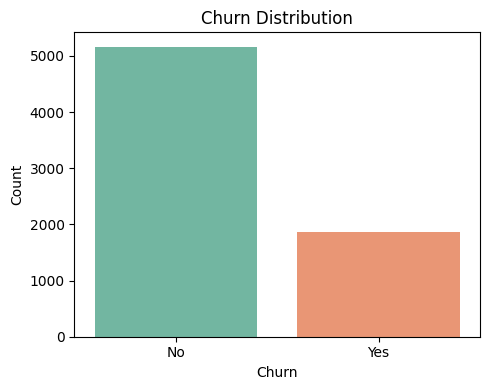

In [9]:
# Check Customer's Churn Distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='Churn', hue='Churn', palette='Set2', legend=False)
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

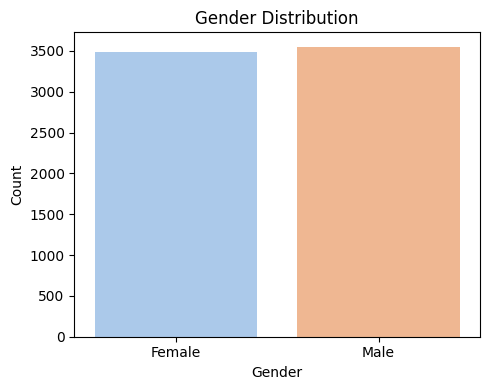

In [10]:
# Check Customer's Gender Distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='gender', hue='gender', palette='pastel', legend=False)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


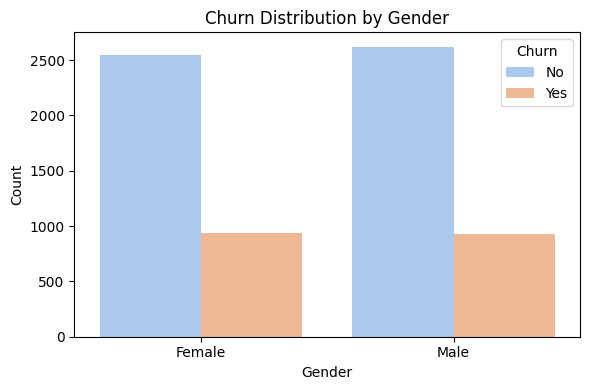

In [11]:
# Check Customer's Gender Distribution by Churn
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='gender', hue='Churn', palette='pastel')
plt.title("Churn Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Churn")
plt.tight_layout()
plt.show()

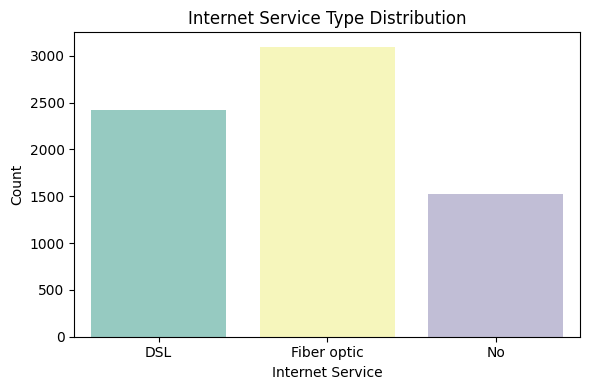

In [12]:
# Check Customer's Internet Service Type Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='InternetService', hue='InternetService', palette='Set3', legend=False)
plt.title("Internet Service Type Distribution")
plt.xlabel("Internet Service")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

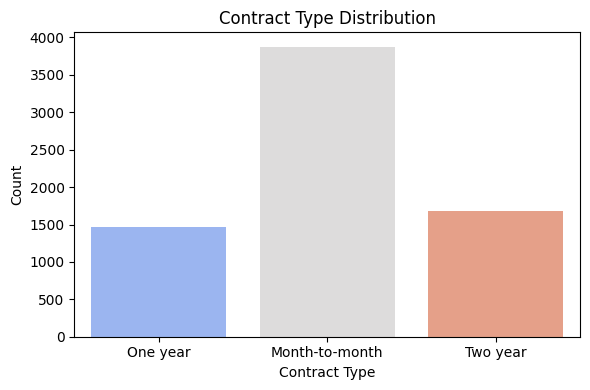

In [13]:
# Contract Type Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Contract', hue='Contract', palette='coolwarm', legend=False)
plt.title("Contract Type Distribution")
plt.xlabel("Contract Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

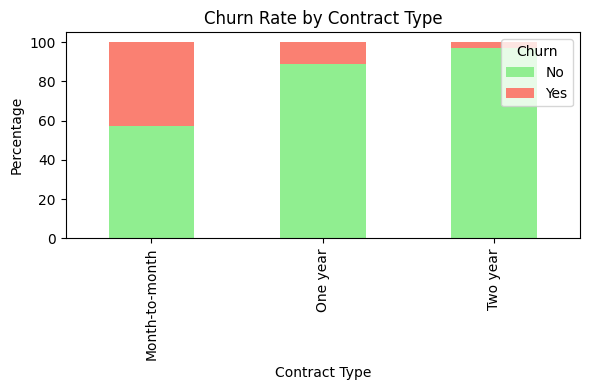

In [14]:
# Churn Rate by Contract Type
contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
contract_churn.plot(kind='bar', stacked=True, color=['lightgreen', 'salmon'], figsize=(6, 4))
plt.title("Churn Rate by Contract Type")
plt.ylabel("Percentage")
plt.xlabel("Contract Type")
plt.legend(title='Churn', loc='upper right')
plt.tight_layout()
plt.show()

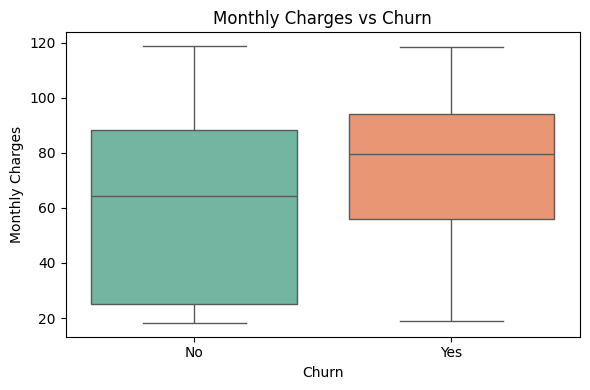

In [15]:
# Avg MonthlyCharges for Churned vs Not Churned
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', hue='Churn', palette='Set2')
plt.title("Monthly Charges vs Churn")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.tight_layout()
plt.show()

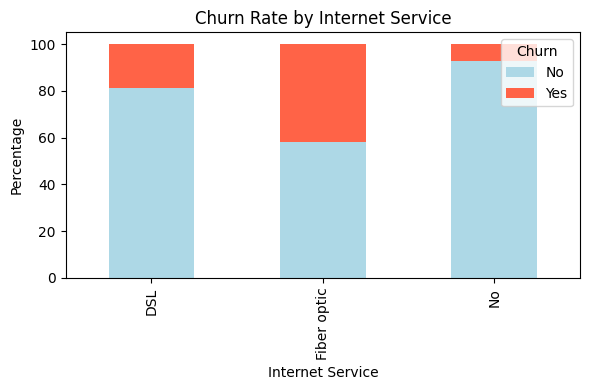

In [16]:
# Churn Rate by Internet Service Type
internet_churn = pd.crosstab(df['InternetService'], df['Churn'], normalize='index') * 100
internet_churn.plot(kind='bar', stacked=True, color=['lightblue', 'tomato'], figsize=(6, 4))
plt.title("Churn Rate by Internet Service")
plt.ylabel("Percentage")
plt.xlabel("Internet Service")
plt.legend(title='Churn', loc='upper right')
plt.tight_layout()
plt.show()

#### Exploratory Data Analysis (EDA) Summary

1. Churn Distribution
- The dataset is imbalanced — most customers did **not churn**.
- Use SMOTE or resampling for modeling.
- Accuracy is not reliable; use AUC-ROC, F1, and recall.



2. Gender Distribution
- Male and female customers are nearly balanced.
- Gender may not be a strong predictor of churn.



3. Internet Service Type
- Majority use **Fiber optic** or **DSL**.
- Customers with **no internet** rarely churn.



4. Contract Type
- Most customers are on **Month-to-month** contracts.
- Longer contracts (1–2 years) may reduce churn.



5. Churn Rate by Contract
- **Month-to-month** customers churn the most.
- Loyalty programs for long-term contracts could reduce churn.



6. Monthly Charges vs. Churn
- Churned customers have **higher monthly charges**.
- Price sensitivity may be a churn driver.



7. Churn Rate by Internet Service
- **Fiber optic** users churn more than others.
- Service quality vs. price perception could be an issue.



8. Gender vs. Churn
- No significant difference in churn between genders.
- Gender is likely **not a key feature**.


#### Key Takeaways
- Important features for modeling: `Contract`, `InternetService`, `MonthlyCharges`, `tenure`, `TotalCharges`.
- Data imbalance must be addressed in modeling.
- Focus on high-churn segments (e.g., fiber optic + month-to-month + high cost).

---

#### Data Pre-processing

We will conduct:
- Handle missing values
- Encode categorical features (binary & one-hot)
- Scale numerical features
- Handle outliers (IQR/Z-score)
- Feature engineering (e.g., TotalSpent, HasInternet)
- Balance target classes (SMOTE or other)
- Convert target `Churn` to binary integer
- Stratified train-test split
- Check multicollinearity between features
- Detect and prevent data leakage

Handle any remaining missing values (If there's any)

In [17]:
# Check if there are any extra missing values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Churn               0
dtype: int64

No remaining/extra missing values on the dataset.

In [18]:
# Check the dataset
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,...,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,One year,Yes,Mailed check,65.6,...,Yes,No,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,Male,0,No,No,9,Month-to-month,No,Mailed check,59.9,...,Yes,Yes,DSL,No,No,No,No,No,Yes,No
2,0004-TLHLJ,Male,0,No,No,4,Month-to-month,Yes,Electronic check,73.9,...,Yes,No,Fiber optic,No,No,Yes,No,No,No,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Month-to-month,Yes,Electronic check,98.0,...,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Month-to-month,Yes,Mailed check,83.9,...,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Yes


We can drop CustomerID column. We will encode the columns that consist of 'Yes' and 'No' values to 0 for No and 1 for Yes. The 'Contract', 'PaymentMethod', 'InternetService', using OneHot Encoder.

In [19]:
# Pre-process function
def preprocess_telco_full(df, handle_outliers=True):
    df = df.copy()

    # 1. Drop irrelevant column
    if 'customerID' in df.columns:
        df.drop('customerID', axis=1, inplace=True)

    # 2. Convert TotalCharges to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(0)

    # 3. Encode target 'Churn'
    if df['Churn'].dtype == 'object':
        df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    # 4. Binary encoding
    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
    for col in binary_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].map({'Yes': 1, 'No': 0})

    # 5. One-hot encoding
    cat_cols = [
        'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport',
        'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
    ]
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # 6. Feature engineering
    df['TotalSpent'] = df['MonthlyCharges'] * df['tenure']
    df['HasInternet'] = df.get('InternetService_Fiber optic', 0) + df.get('InternetService_DSL', 0)
    df['IsLongContract'] = df.get('Contract_One year', 0) + df.get('Contract_Two year', 0)

    # 7. Handle outliers (IQR capping)
    if handle_outliers:
        numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalSpent']
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            df[col] = np.where(df[col] < lower, lower,
                        np.where(df[col] > upper, upper, df[col]))

    return df

# Create new df with applied pre-processing
df_clean = preprocess_telco_full(df, handle_outliers=True)

In [20]:
df_clean.head()

,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,PhoneService,Churn,gender_Male,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalSpent,HasInternet,IsLongContract
0,0,1,1,9.0,1,65.6,593.30,1,0,False,...,False,False,True,False,False,False,True,590.4,0,True
1,0,0,0,9.0,0,59.9,542.40,1,0,True,...,False,True,False,False,False,False,True,539.1,0,False
2,0,0,0,4.0,1,73.9,280.85,1,1,True,...,False,False,False,False,False,True,False,295.6,1,False
3,1,1,0,13.0,1,98.0,1237.85,1,1,True,...,False,True,False,False,False,True,False,1274.0,1,False
4,1,1,0,3.0,1,83.9,267.40,1,1,False,...,False,False,False,False,False,False,True,251.7,1,False


<Axes: >

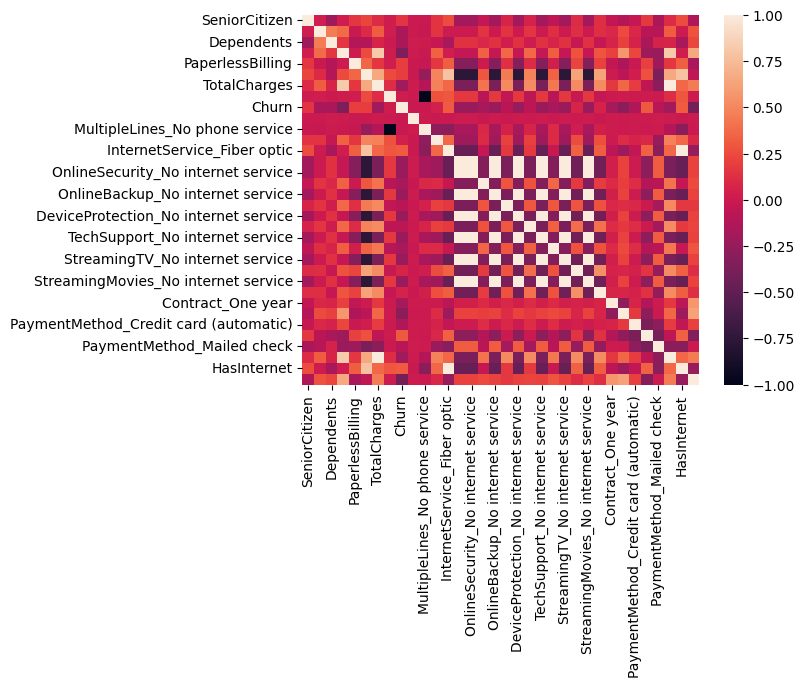

In [21]:
# Correlation analysis
sns.heatmap(df_clean.corr())

Feature Selection and Scaling feature

In [22]:
# Selected column
# selected_features = [
#     'tenure',
#     'MonthlyCharges',
#     'Contract_One year',
#     'Contract_Two year',
#     'InternetService_Fiber optic',
#     'OnlineSecurity',
#     'OnlineBackup',
#     'TechSupport',
#     'DeviceProtection',
#     'PaymentMethod_Electronic check',
#     'PaperlessBilling',
#     'SeniorCitizen',
#     'Partner',
#     'Dependents',
#     'StreamingTV',
#     'StreamingMovies'
# ]

X = df_clean.drop(columns='Churn', axis=1)
y = df_clean['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

---
#### Model Building
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost

In [23]:
# Define search param
def define_search_space(trial, model_name):
    search_spaces = {
        "Logistic Regression": lambda: {
            "C": trial.suggest_float("C", 1e-4, 1e2, log=True),
            "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
            "max_iter": trial.suggest_int("max_iter", 500, 2000),
        },
        "Decision Tree": lambda: {
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 32),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 32),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        },
        "Random Forest": lambda: {
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "max_depth": trial.suggest_int("max_depth", 5, 50),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 16),
        },
        "XGBoost": lambda: {
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        }
    }

    if model_name not in search_spaces:
        raise ValueError(f"No search space defined for model: {model_name}")

    return search_spaces[model_name]()

In [24]:
# Get fixed params
def get_fixed_params(model_name):
    fixed = {'random_state': 42}
    if model_name in ["Random Forest", "XGBoost"]:
        fixed['n_jobs'] = -1
    if model_name == "XGBoost":
        fixed['use_label_encoder'] = False
        fixed['eval_metric'] = 'logloss'
    return fixed

In [25]:
# Build Pipeline
def build_pipeline(model_class, params):
    model = model_class(**params)
    return Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

In [26]:
# Objective Function
def objective(trial, model_class, model_name):
    params = define_search_space(trial, model_name)
    params.update(get_fixed_params(model_name))

    pipeline = build_pipeline(model_class, params)
    score = cross_val_score(pipeline, X_train, y_train, cv=3, n_jobs=-1, scoring='roc_auc')
    return score.mean()

In [27]:
# Evaluation metric
def print_eval_report(model_name, y_test, y_pred, y_prob):
    print(f"--- Final Evaluation Results for: {model_name} (After Hyperparameter Tuning) ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC Score on Test Set: {roc_auc_score(y_test, y_prob):.4f}")
    print("=" * 60 + "\n")

In [28]:
# Confusion Matrix Plot
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


🔍 Tuning model: Logistic Regression


Tuning Logistic Regression: 100%|██████████| 25/25 [00:14<00:00,  1.76it/s]


✅ Best Parameters for Logistic Regression: {'C': 0.4689400963537689, 'solver': 'saga', 'max_iter': 1049, 'random_state': 42}

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1033
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.74      0.76      1407



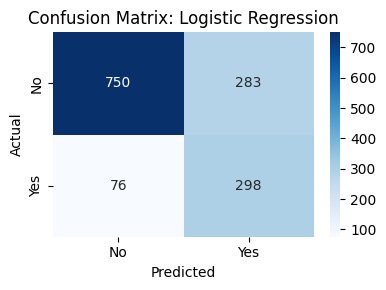


🔍 Tuning model: Decision Tree


Tuning Decision Tree: 100%|██████████| 25/25 [00:01<00:00, 12.70it/s]


✅ Best Parameters for Decision Tree: {'max_depth': 4, 'min_samples_split': 26, 'min_samples_leaf': 25, 'criterion': 'entropy', 'random_state': 42}

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1033
           1       0.51      0.76      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.74      0.76      1407



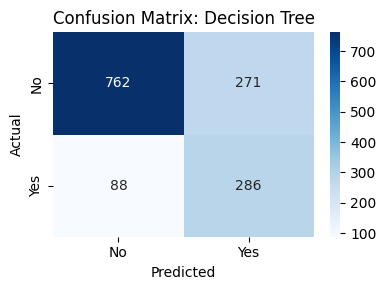


🔍 Tuning model: Random Forest


Tuning Random Forest: 100%|██████████| 25/25 [00:48<00:00,  1.95s/it]


✅ Best Parameters for Random Forest: {'n_estimators': 613, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 3, 'random_state': 42, 'n_jobs': -1}

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1033
           1       0.54      0.78      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.76      0.77      1407



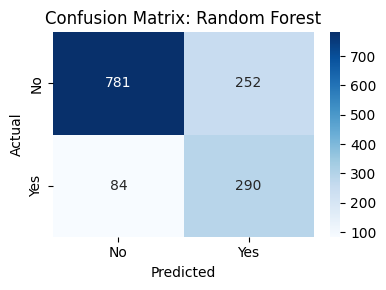


🔍 Tuning model: XGBoost


Tuning XGBoost: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]
e:\Program\Anaconda\envs\kaggle\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:12:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best Parameters for XGBoost: {'n_estimators': 166, 'max_depth': 6, 'learning_rate': 0.019972671123413333, 'subsample': 0.954660201039391, 'colsample_bytree': 0.6293899908000085, 'random_state': 42, 'n_jobs': -1, 'use_label_encoder': False, 'eval_metric': 'logloss'}

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1033
           1       0.57      0.71      0.63       374

    accuracy                           0.78      1407
   macro avg       0.73      0.76      0.74      1407
weighted avg       0.80      0.78      0.79      1407



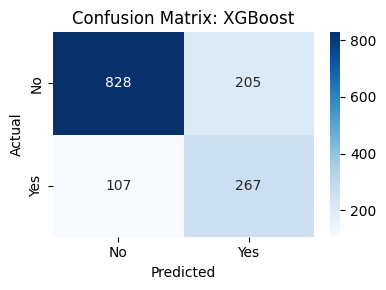

In [29]:
# Model tuning & Training
models_to_tune = {
    "Logistic Regression": LogisticRegression,
    "Decision Tree": DecisionTreeClassifier,
    "Random Forest": RandomForestClassifier,
    "XGBoost": XGBClassifier
}

best_pipelines = {}

model_accuracies = {}

# Tuning dan evaluasi
for model_name, model_class in models_to_tune.items():
    print(f"\n🔍 Tuning model: {model_name}")
    n_trials = 25
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
    objective_func = partial(objective, model_class=model_class, model_name=model_name)

    # Progress bar tqdm
    for _ in tqdm(range(n_trials), desc=f"Tuning {model_name}", leave=True):
        study.optimize(objective_func, n_trials=1, catch=(Exception,))

    # Ambil parameter terbaik
    best_params = study.best_params
    best_params.update(get_fixed_params(model_name))
    print(f"✅ Best Parameters for {model_name}: {best_params}")

    # Train model dengan pipeline
    final_pipeline = build_pipeline(model_class, best_params)
    final_pipeline.fit(X_train, y_train)
    best_pipelines[model_name] = final_pipeline

    # Predict dan evaluate
    y_pred = final_pipeline.predict(X_test)
    y_prob = final_pipeline.predict_proba(X_test)[:, 1]
    
    print(f"\n--- {model_name} ---")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, model_name)

    # Simpan akurasi
    acc = accuracy_score(y_test, y_pred)
    model_accuracies[model_name] = acc

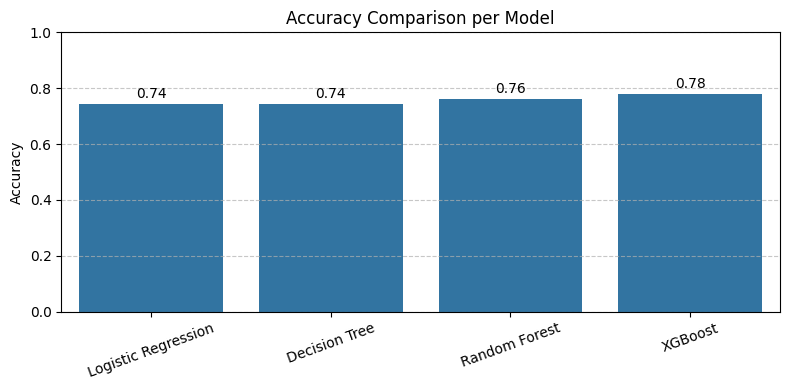

In [30]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()))

plt.title("Accuracy Comparison per Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add label
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.01,
            f"{height:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()